In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, LassoLarsCV
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time
import seaborn as sns
from scipy.stats import norm, probplot
from sklearn.datasets import make_regression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

In [2]:
# Define the custom confusion matrix plotting function
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cf using a Seaborn heatmap visualization.
    Arguments:
    - cf:            confusion matrix to be visualized
    - group_names:   List of strings that represent the labels row by row to be shown in each square.
    - categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    - count:         If True, show the raw number in the confusion matrix. Default is True.
    - percent:       If True, show the proportions for each category. Default is True.
    - cbar:          If True, show the color bar. Default is True.
    - xyticks:       If True, show x and y ticks. Default is True.
    - xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the plot. Default is True.
    - sum_stats:     If True, display summary statistics below the plot. Default is True.
    - figsize:       Tuple representing the figure size. Default will be the rcParams value.
    - cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
    - title:         Title for the heatmap. Default is None.
    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize is None:
        # Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if not xyticks:
        # Do not show categories if xyticks is False
        categories=False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    if title:
        plt.title(title)

In [3]:
wave_df = pd.read_csv("WEC_Perth_49.csv")
wave_df.shape

(36043, 149)

In [4]:
wave_df

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,...,Power42,Power43,Power44,Power45,Power46,Power47,Power48,Power49,qW,Total_Power
0,600.0,0.0,546.16,37.50,489.79,74.88,432.47,112.05,650.0,0.0,...,88867.92,98844.30,101283.59,98934.63,101624.58,100915.03,99625.68,96704.34,0.87,4102461.43
1,593.0,12.0,546.16,37.50,489.79,74.88,432.47,112.05,644.0,8.0,...,88896.55,98759.79,101346.07,98873.59,101629.01,100934.53,99606.13,96718.39,0.87,4103361.41
2,593.0,12.0,546.16,37.50,489.79,74.88,432.47,112.05,644.0,8.0,...,88919.83,98746.68,101346.15,98875.57,101618.32,100941.00,99611.35,96719.14,0.87,4103680.44
3,593.0,12.0,546.16,37.50,489.79,74.88,432.47,112.05,644.0,8.0,...,88855.14,98760.96,101338.59,98971.58,101632.28,100943.59,99589.25,96735.04,0.87,4105661.06
4,200.0,0.0,146.17,37.53,89.76,74.93,32.40,112.18,400.0,0.0,...,88005.30,98630.24,100432.73,98803.01,101064.48,100948.38,99028.87,96286.71,0.79,3752648.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36038,100.0,250.0,250.00,250.00,300.00,200.00,400.00,100.00,900.0,150.0,...,100382.68,90042.10,99539.28,100219.37,70180.74,98693.05,100739.06,100530.96,0.86,4048188.53
36039,250.0,200.0,500.00,150.00,350.00,200.00,700.00,500.00,50.0,250.0,...,97576.89,89874.39,99413.89,83966.40,74140.17,66977.16,99768.78,92788.85,0.85,4033017.16
36040,200.0,100.0,400.00,100.00,350.00,500.00,750.00,200.00,700.0,250.0,...,101072.75,98181.96,77322.16,77632.27,102878.91,83002.93,91852.61,98283.28,0.86,4048053.62
36041,500.0,250.0,350.00,350.00,1000.00,250.00,550.00,150.00,800.0,0.0,...,99078.22,101120.28,73597.78,102042.99,58438.65,98804.39,66383.44,97423.85,0.86,4062515.64


In [5]:
wave_df.columns

Index(['X1', 'Y1', 'X2', 'Y2', 'X3', 'Y3', 'X4', 'Y4', 'X5', 'Y5',
       ...
       'Power42', 'Power43', 'Power44', 'Power45', 'Power46', 'Power47',
       'Power48', 'Power49', 'qW', 'Total_Power'],
      dtype='object', length=149)

In [6]:
total_power_description = wave_df['Total_Power'].describe()
print("Descriptive Statistics for 'Total_Power':")
print(f"Count: {total_power_description['count']}")
print(f"Mean: {total_power_description['mean']:.2f}")
print(f"Standard Deviation: {total_power_description['std']:.2f}")
print(f"Minimum: {total_power_description['min']:.2f}")
print(f"25th Percentile: {total_power_description['25%']:.2f}")
print(f"Median (50th Percentile): {total_power_description['50%']:.2f}")
print(f"75th Percentile: {total_power_description['75%']:.2f}")
print(f"Maximum: {total_power_description['max']:.2f}")

Descriptive Statistics for 'Total_Power':
Count: 36043.0
Mean: 3938246.46
Standard Deviation: 122617.15
Minimum: 3388944.15
25th Percentile: 3847334.53
Median (50th Percentile): 3931540.55
75th Percentile: 4063622.69
Maximum: 4177658.97


In [7]:
total_missing = wave_df.isnull().sum().sort_values(ascending=False)
total_missing.head()

X1        0
X48       0
X49       0
Y49       0
Power1    0
dtype: int64

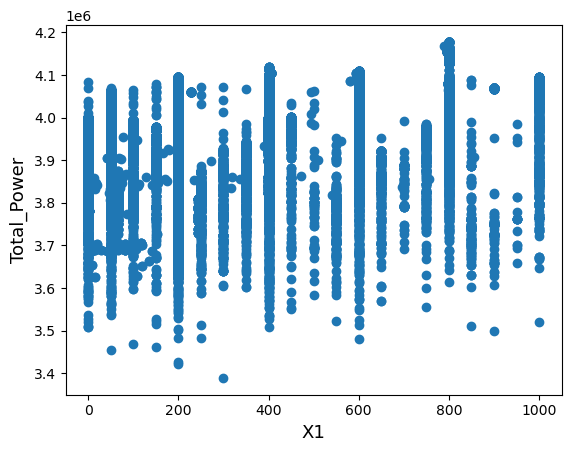

In [8]:
fig, ax = plt.subplots()
ax.scatter(x=wave_df["X1"], y=wave_df["Total_Power"])
plt.ylabel("Total_Power", fontsize=13)
plt.xlabel("X1", fontsize=13)
plt.show()

/var/folders/sr/jl7fn_fj5_50nxl5r18wxlj80000gn/T/ipykernel_2567/724532064.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(wave_df["Total_Power"], fit=norm)



 mu = 3938246.46 and sigma = 122615.45



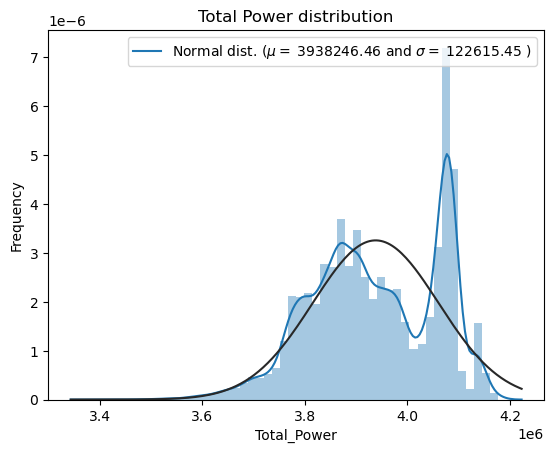

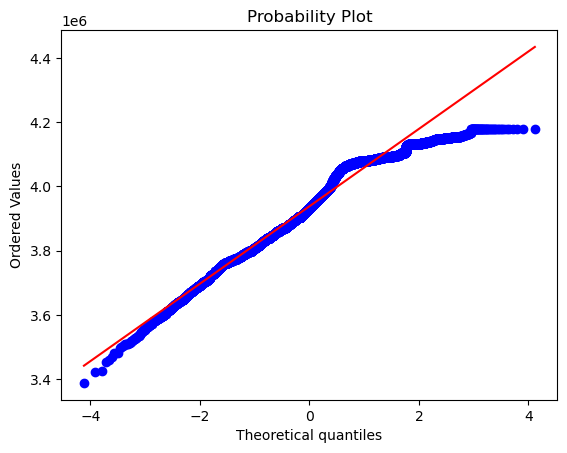

In [9]:
sns.distplot(wave_df["Total_Power"], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(wave_df["Total_Power"])
print("\n mu = {:.2f} and sigma = {:.2f}\n".format(mu, sigma))

# Now plot the distribution
plt.legend(
    ["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )".format(mu, sigma)], loc="best"
)
plt.ylabel("Frequency")
plt.title("Total Power distribution")

# Get also the QQ-plot
fig = plt.figure()
res = probplot(wave_df["Total_Power"], plot=plt)
plt.show()

/var/folders/sr/jl7fn_fj5_50nxl5r18wxlj80000gn/T/ipykernel_2567/1917849728.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(wave_df["Total_Power_normalized"], fit=norm)



 mu = 15.19 and sigma = 0.03



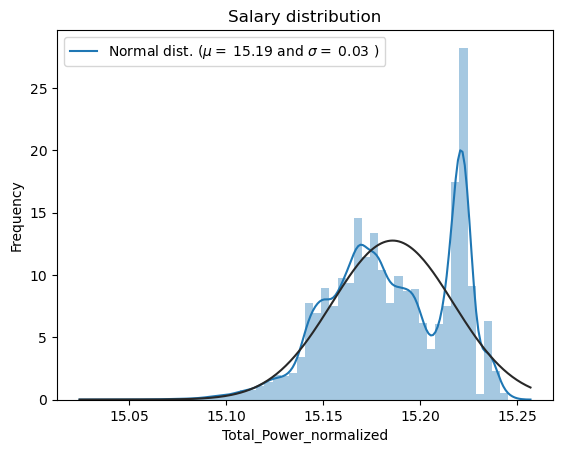

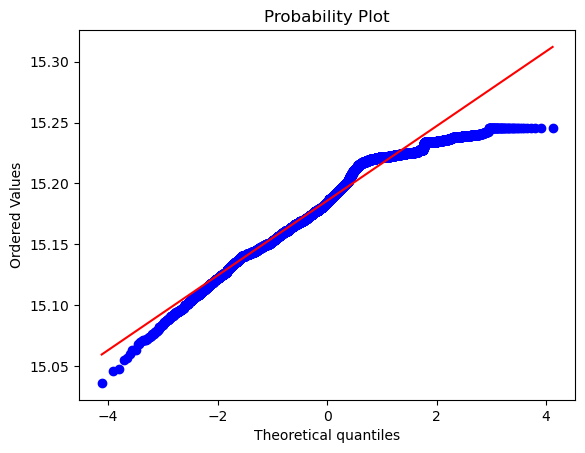

In [10]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
wave_df["Total_Power_normalized"] = np.log1p(wave_df["Total_Power"])

# Check the new distribution
sns.distplot(wave_df["Total_Power_normalized"], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(wave_df["Total_Power_normalized"])
print("\n mu = {:.2f} and sigma = {:.2f}\n".format(mu, sigma))

# Now plot the distribution
plt.legend(
    ["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )".format(mu, sigma)], loc="best"
)
plt.ylabel("Frequency")
plt.title("Salary distribution")

# Get also the QQ-plot
fig = plt.figure()
res = probplot(wave_df["Total_Power_normalized"], plot=plt)
plt.show()

In [11]:
corrmat = wave_df.corr()
tp_correlations = corrmat['X10']
print(tp_correlations.sort_values(ascending=False).head(20))

X10            1.000000
Power10        0.775019
X9             0.568296
Power9         0.528050
X11            0.469674
Power11        0.415281
X22            0.365280
X29            0.343628
Y7             0.335187
X36            0.332663
Y4             0.321693
Power22        0.313907
X30            0.293203
Power12        0.292470
Y49            0.281972
X17            0.267511
X43            0.266576
X12            0.264988
qW             0.260970
Total_Power    0.255393
Name: X10, dtype: float64


#### I think i would have to strip all the power features since they are so highly correlated to total power

In [12]:
# List of columns to drop
cols_to_drop = [f'Power{i}' for i in range(1, 50)]

# Drop the columns
wave_df = wave_df.drop(columns=cols_to_drop)
wave_df = wave_df.drop(columns="qW")

wave_df.head()

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,...,X46,Y46,X47,Y47,X48,Y48,X49,Y49,Total_Power,Total_Power_normalized
0,600.0,0.0,546.16,37.50,489.79,74.88,432.47,112.05,650.0,0.0,...,346.16,837.50,289.79,874.88,232.47,912.05,0.0,1010.0,4102461.43,15.227098
1,593.0,12.0,546.16,37.50,489.79,74.88,432.47,112.05,644.0,8.0,...,346.16,837.50,289.79,874.88,232.47,912.05,0.0,1010.0,4103361.41,15.227317
2,593.0,12.0,546.16,37.50,489.79,74.88,432.47,112.05,644.0,8.0,...,346.16,837.50,289.79,874.88,232.47,912.05,0.0,1010.0,4103680.44,15.227395
3,593.0,12.0,546.16,37.50,489.79,74.88,432.47,112.05,644.0,8.0,...,346.16,837.50,289.79,874.88,232.47,912.05,0.0,1010.0,4105661.06,15.227878
4,200.0,0.0,146.17,37.53,89.76,74.93,32.40,112.18,400.0,0.0,...,746.17,837.53,689.76,874.93,632.40,912.18,0.0,1010.0,3752648.77,15.137973


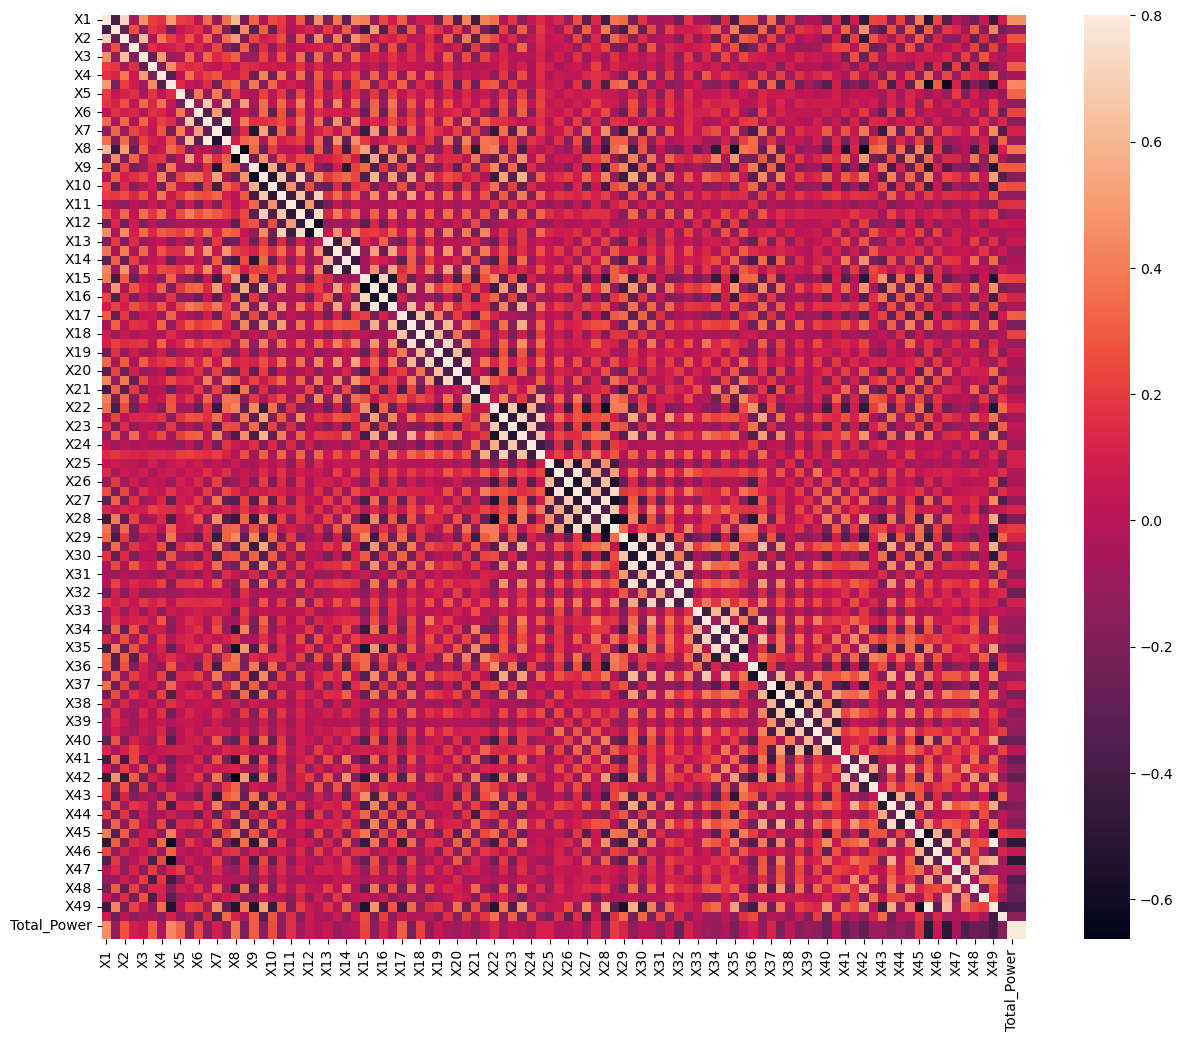

In [13]:
# Exclude non-numeric columns
corrmat = wave_df.corr()

f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat, vmax=0.8, square=True);

In [14]:
wave_df.shape

(36043, 100)

## Lasso

In [15]:
target = 'Total_Power_normalized'
predictors = wave_df.columns.difference([target, 'Total_Power'])
lasso_results = []

In [16]:
# split data

X = wave_df[predictors]
y = wave_df[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28834, 98), (7209, 98), (28834,), (7209,))

In [17]:
# Assuming X_train and y_train are your features and target variables
from sklearn.linear_model import LinearRegression


linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Get coefficients
linear_coefficients = linear_model.coef_
linear_coefficients


array([ 1.73391024e-05,  8.64824699e-06,  7.90986732e-06,  8.49955243e-06,
        7.33318204e-06,  7.06709355e-06,  5.21939466e-06, -1.30602034e-06,
        3.28202291e-06,  3.60380912e-06,  5.82300123e-06,  1.32163068e-05,
        3.18284973e-07,  2.13973278e-06,  1.69792510e-06,  1.72864941e-06,
       -1.58611233e-06,  1.48839382e-06, -2.17734311e-06,  5.38063820e-06,
        3.68034399e-07,  7.87461206e-07,  3.42460101e-06, -3.25186336e-06,
       -5.36493481e-06, -7.86363076e-06,  5.69742899e-07, -7.10564533e-07,
       -7.25983596e-06, -2.88272589e-06, -5.97500065e-06, -7.49567332e-06,
       -9.55517451e-06,  9.03225087e-06, -3.75246262e-06, -1.45983453e-05,
       -1.18478304e-05, -9.94906527e-06, -7.46031216e-06, -1.10880664e-05,
       -5.42062694e-06, -4.43326408e-06, -1.55083445e-05, -1.40273428e-05,
        1.16959844e-05,  1.16872084e-05,  8.65967304e-06,  1.23706712e-05,
        1.55631884e-05, -6.87760438e-05, -1.87749848e-05, -1.30491284e-05,
        1.77144966e-07, -

In [18]:
### LASSO model

# Create a pipeline with StandardScaler and LassoCV
lasso = make_pipeline(StandardScaler(), LassoCV(cv=10, random_state = 8, n_jobs=-1))

start_time = time.time()

# Fit the model
lasso.fit(X_train, y_train)

# Print the chosen alpha
lasso_cv = lasso.named_steps['lassocv']
best_alpha = lasso_cv.alpha_
print("Optimal alpha:", best_alpha)

Optimal alpha: 1.5521488953661985e-05


In [19]:
lasso_final = Lasso(alpha=best_alpha)

# Fit the final model to the training data
lasso_final.fit(X_train, y_train)

# Predict on test data and time
y_pred = lasso_final.predict(X_test)
end_time = time.time()

In [20]:
estimation_time = end_time - start_time
print(estimation_time)

2.8462109565734863


In [21]:
lasso_coefficients = lasso_final.coef_
lasso_coefficients

array([ 1.73468816e-05,  8.64837905e-06,  7.91295810e-06,  8.49479096e-06,
        7.33494279e-06,  7.06519562e-06,  5.21903456e-06, -1.30606747e-06,
        3.28574627e-06,  3.60283463e-06,  5.82223215e-06,  1.32174097e-05,
        3.17202307e-07,  2.14055008e-06,  1.69770756e-06,  1.72823574e-06,
       -1.58635063e-06,  1.48596450e-06, -2.17397147e-06,  5.37970411e-06,
        3.66500293e-07,  7.88106877e-07,  3.41753909e-06, -3.24914821e-06,
       -5.36655684e-06, -7.86184332e-06,  5.70268030e-07, -7.13599170e-07,
       -7.25656030e-06, -2.88330525e-06, -5.97594229e-06, -7.49589363e-06,
       -9.55560145e-06,  9.02944692e-06, -3.75494164e-06, -1.45961564e-05,
       -1.18486903e-05, -9.95264995e-06, -7.45558208e-06, -1.10851915e-05,
       -5.41636930e-06, -4.43235210e-06, -1.55113140e-05, -1.40269944e-05,
        1.16989659e-05,  1.16843400e-05,  8.66626979e-06,  1.23681386e-05,
        1.55623331e-05, -6.86964017e-05, -1.87503526e-05, -1.30099668e-05,
        1.27602702e-07, -

In [22]:
# Print list of new coefficients of all features
coefficients = pd.DataFrame({'Feature': predictors, 'Coefficient': lasso_final.coef_})
coefficients

,Feature,Coefficient
0,X1,0.000017
1,X10,0.000009
2,X11,0.000008
3,X12,0.000008
4,X13,0.000007
...,...,...
93,Y5,-0.000037
94,Y6,0.000042
95,Y7,-0.000070
96,Y8,0.000039


In [23]:
# Create a DataFrame to compare the coefficients
coefficients_df = pd.DataFrame({
    'Feature_Index': np.arange(len(X.columns)),
    'Feature': X.columns,
    'Initial_Coefficients': linear_coefficients,
    'Lasso_Coefficients': lasso_coefficients
})

zero_indices = coefficients_df[coefficients_df['Lasso_Coefficients'] == 0]['Feature_Index']

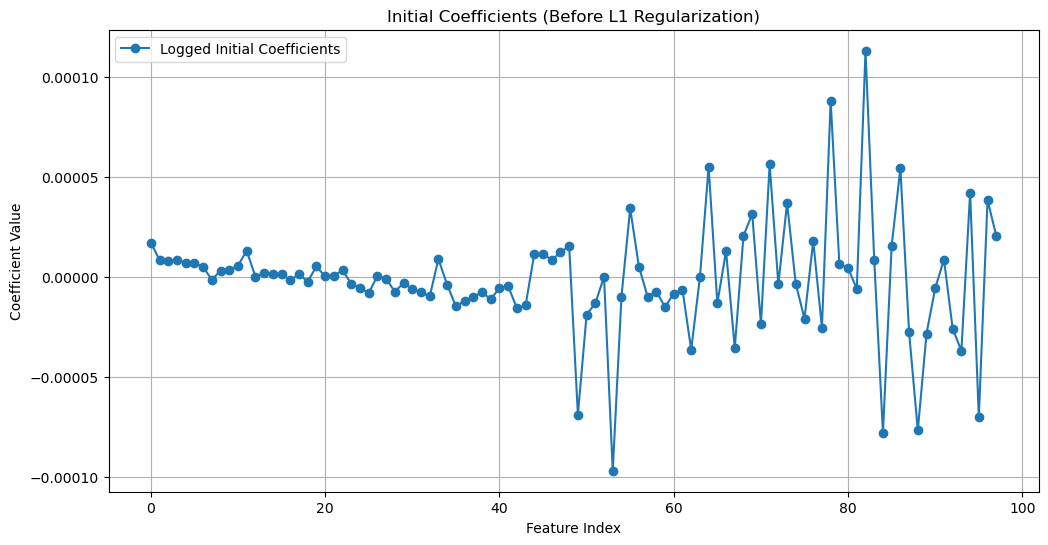

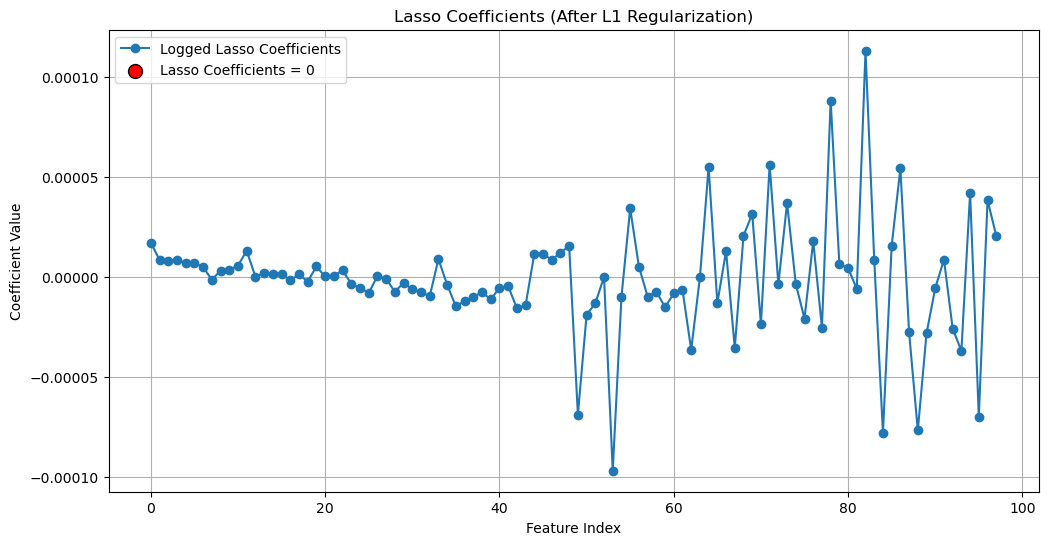

In [24]:
# Plot logged initial coefficients
plt.figure(figsize=(12, 6))
plt.plot(coefficients_df['Feature_Index'], coefficients_df['Initial_Coefficients'], marker='o', label='Logged Initial Coefficients', linestyle='-')
#plt.xticks(coefficients_df['Feature_Index'])
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Initial Coefficients (Before L1 Regularization)')
plt.legend()
plt.grid(True)
plt.show()

# Plot logged Lasso coefficients
plt.figure(figsize=(12, 6))
plt.plot(coefficients_df['Feature_Index'], coefficients_df['Lasso_Coefficients'], marker='o', label='Logged Lasso Coefficients', linestyle='-')
#plt.xticks(coefficients_df['Feature_Index'])
plt.scatter(zero_indices, np.zeros(len(zero_indices)), color='red', edgecolor='black', s=100, zorder=5, label='Lasso Coefficients = 0')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficients (After L1 Regularization)')
plt.legend()
plt.grid(True)
plt.show()

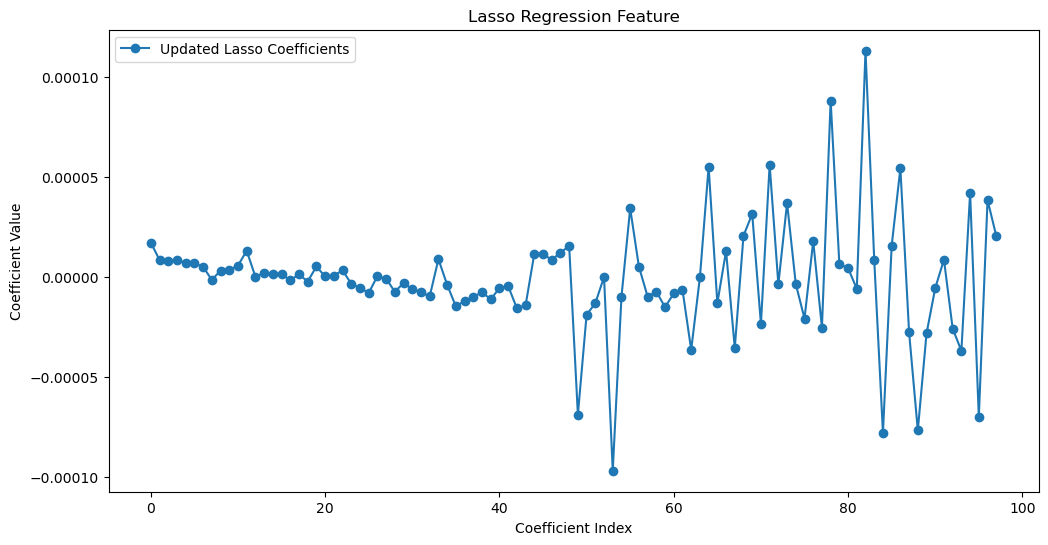

In [25]:
# Plot the results with different labels
plt.figure(figsize=(12, 6))
plt.plot(coefficients['Coefficient'], marker='o', label='Updated Lasso Coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.legend()
plt.title('Lasso Regression Feature')
plt.show()

In [26]:
# Reverse the log transformation
original_scale_pred = np.expm1(y_pred)
original_scale_y_test = np.expm1(y_test)
original_scale_y_train = np.expm1(y_train)

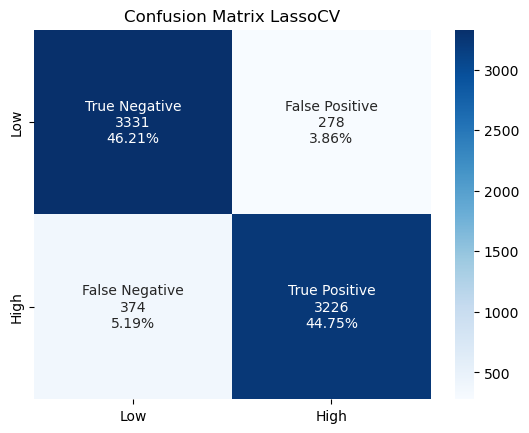

In [27]:
### Compute evaluation statistics

rmse = np.sqrt(mean_squared_error(original_scale_y_test, original_scale_pred))

# Create binary predictions for confusion matrix
y_pred_binary = (original_scale_pred > original_scale_y_test.median()).astype(int)
y_true_binary = (original_scale_y_test > original_scale_y_test.median()).astype(int)

# Confusion matrix
cm = confusion_matrix(y_true_binary, y_pred_binary)
tn, fp, fn, tp = cm.ravel()
lasso_false_positive_rate = fp / (fp + tn)
lasso_false_negative_rate = fn / (fn + tp)

# Store the results
lasso_results.append({
    'model': 'LassoCV',
    'estimation_time': end_time - start_time,
    'rmse': rmse,
    'false_positive_rate': lasso_false_positive_rate,
    'false_negative_rate': lasso_false_negative_rate
})

labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
categories = ['Low', 'High']
make_confusion_matrix(cm, 
                        group_names=labels, 
                        categories=categories, 
                        cmap='Blues', 
                        title='Confusion Matrix LassoCV')

In [28]:
# Display the results
lasso_results_df = pd.DataFrame(lasso_results)
lasso_results_df

,model,estimation_time,rmse,false_positive_rate,false_negative_rate
0,LassoCV,2.846211,50113.191554,0.07703,0.103889


In [29]:
lasso_results_df.to_csv('metrics.csv', index=False)